<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2024/blob/main/notebooks/es11/MetodiAI_Fis2024_Es11_AE_AnomalyDetection_SOLUZIONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning e Anomaly Detection con Auto-Encoders

scopo: familiarizzare con la progettazione e l'uso di archietture AE

DL tool: pytorch

### tasks ###

1.   implementazione di un AE allenato come compressore di informazione e confronto con PCA
2.   uso di un AE come algoritmo di Anomaly Detection e applicazione al dataset MNIST


**Datasets:**

*   [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)

In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.3.0+cu121
0.18.0+cu121


il dataset MNIST è costituito da immagini di caratteri numerici (0,1,...,9) scritti a mano corrispondenti a 60k immagini per il training e 10k immagini per il test.

Ogni immagine ha dimensione $(28,28)$ pixel, con un canale di intensità (scala di grigi) a 8 bit (valori di intensità di ogni pixel $\in [0,256]$).

È disponibile in varie librerie per il ML (scikit-learn, torch, tensorflow, librerie esterne...). Prendendo il dataset già disponibile in pytorch possiamo sfruttare il vantaggio di di avere conversioni automatiche in tensori torch e normalizzazioni. Leggendo il dataset da un repository esterno a pytorch come ad esempio openm, in formato di ndarray numpy, dovremo convertire noi i vettori in tensori torch e normalizzarli, ma risulterà più chiaro come usare in generale datset esterni. in questo hands-on utilizzeremo questo secondo approccio.

In [ ]:
# lettura del dataset MNIST da openml usando la libreria sklearn

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converte le label in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


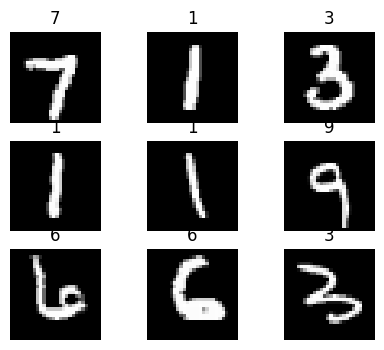

In [ ]:
# grafichiamo 9 immagini random
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [ ]:
# splitting del campione in training e test (80:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


In [ ]:
# le immagini MNIST sono immagini in scala di grigio a 8 bit, ogni pixel assume valore [0,255], quindi in quetso cas è possibile
# normalizzare in [0,1] semplicemente dividendo tutte le immagini per 255

X_train = X_train / 255.
X_test  = X_test / 255.

In [ ]:
# per questa esercitazione è consigliabile usare una GPU
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# conversione in tensori torch dei vettori numpy

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()

# reshape the tensori da (n,784) a (n,1,28,28) come richiesto da conv layer in pytorch

X_train_pt = X_train_pt.view((X_train_pt.shape[0],1,28,28))
X_test_pt = X_test_pt.view((X_test_pt.shape[0],1,28,28))

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([56000, 1, 28, 28])
torch.Size([56000])
torch.Size([14000, 1, 28, 28])
torch.Size([14000])


In [ ]:
# dataset e dataloaders

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

### Definzione del modello di rete neurale.

Archiettura: AE convoluzionale con encoder costituito da 2 layer convoluzionali 2D con kernel_size 4 e stride 2 (per comprimere le rappresentazioni), decoder costituito da ConvTranspose2D. Lo spazio latente z è costituito da un layer denso. Usiamo attivazioni ReLu nella parte convoluzionale e sigmoide nell'ouput in modo da allenare il modello con BCE loss.

In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1)

        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_z = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1) #flatten

        z = self.fc_z(x)

        return z

In [ ]:
# Convolutional Decoder Model
# basato su nn.ConvTranspose2d transpose convolution layer

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)

        return x_recon

In [ ]:
# Istanziamo il modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

print(model_ae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,28,28))
else:
  summary(model_ae, input_size=(1,28,28))

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_z): Linear(in_features=6272, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128, 7, 7]               0
            Linear-5                    [-1, 2]

In [ ]:
# testiamo il modello su un batch

model_ae=model_ae.to(device)

x,_ = next(iter(train_dl)) #è un AE non ci servono le label

x=x.to(device)

z = encoder(x)
xtilde = model_ae(x)


print(z.shape)
print(xtilde.shape)

torch.Size([128, 2])
torch.Size([128, 1, 28, 28])


In [ ]:
# Training


# Istanziamo un nuovo modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy (qui implementata a mano per far vedere come si può scrivere una custom loss (utile per la porssima eserecitazione), qui si puo' usare la BCELoss di pytorch direttamente senza problemi
def vae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784))
    return recon_loss

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# Training loop ... basta solo il loop sul training per fare prima ...

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in train_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = vae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 3.3442, train loss: 0.230507
epoch: 2, time(s): 3.6388, train loss: 0.204858
epoch: 3, time(s): 2.7535, train loss: 0.198750
epoch: 4, time(s): 2.6621, train loss: 0.195536
epoch: 5, time(s): 2.9207, train loss: 0.193426
epoch: 6, time(s): 3.7333, train loss: 0.191921
epoch: 7, time(s): 3.0024, train loss: 0.190799
epoch: 8, time(s): 2.7065, train loss: 0.189823
epoch: 9, time(s): 2.7009, train loss: 0.189169
epoch: 10, time(s): 2.8119, train loss: 0.188468
epoch: 11, time(s): 3.6283, train loss: 0.188034
epoch: 12, time(s): 3.2512, train loss: 0.187362
epoch: 13, time(s): 2.8229, train loss: 0.186877
epoch: 14, time(s): 2.7378, train loss: 0.186583
epoch: 15, time(s): 3.8346, train loss: 0.186103
epoch: 16, time(s): 2.7828, train loss: 0.185833
epoch: 17, time(s): 2.7967, train loss: 0.185552
epoch: 18, time(s): 2.8395, train loss: 0.185279
epoch: 19, time(s): 3.4961, train loss: 0.185044
epoch: 20, time(s): 2.8969, train loss: 0.184801
epoch: 21, time(s): 2.8291, t

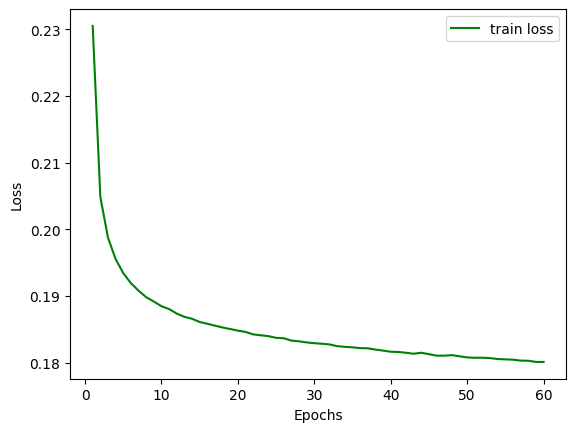

In [ ]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

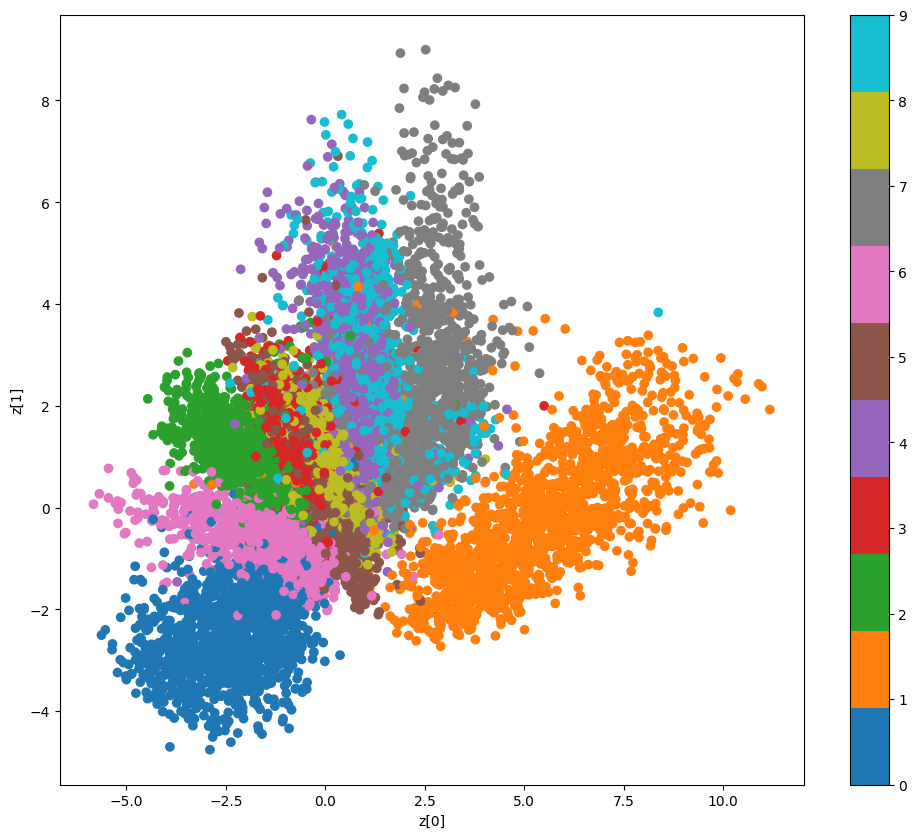

In [ ]:
# Plot dello spazio latente appreso (z1 vs z2)

model_ae.eval()

z = np.empty(shape=(len(test_dl),2))
y = np.empty(shape=(len(test_dl)))
counter = 0
with torch.no_grad():
  for idx, (xb, yb) in enumerate(test_dl):
    xb=xb.to(device)
    zl = encoder(xb)
    z[idx,0] = zl[0,0].item()
    z[idx,1] = zl[0,1].item()
    y[idx] = yb.item()

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

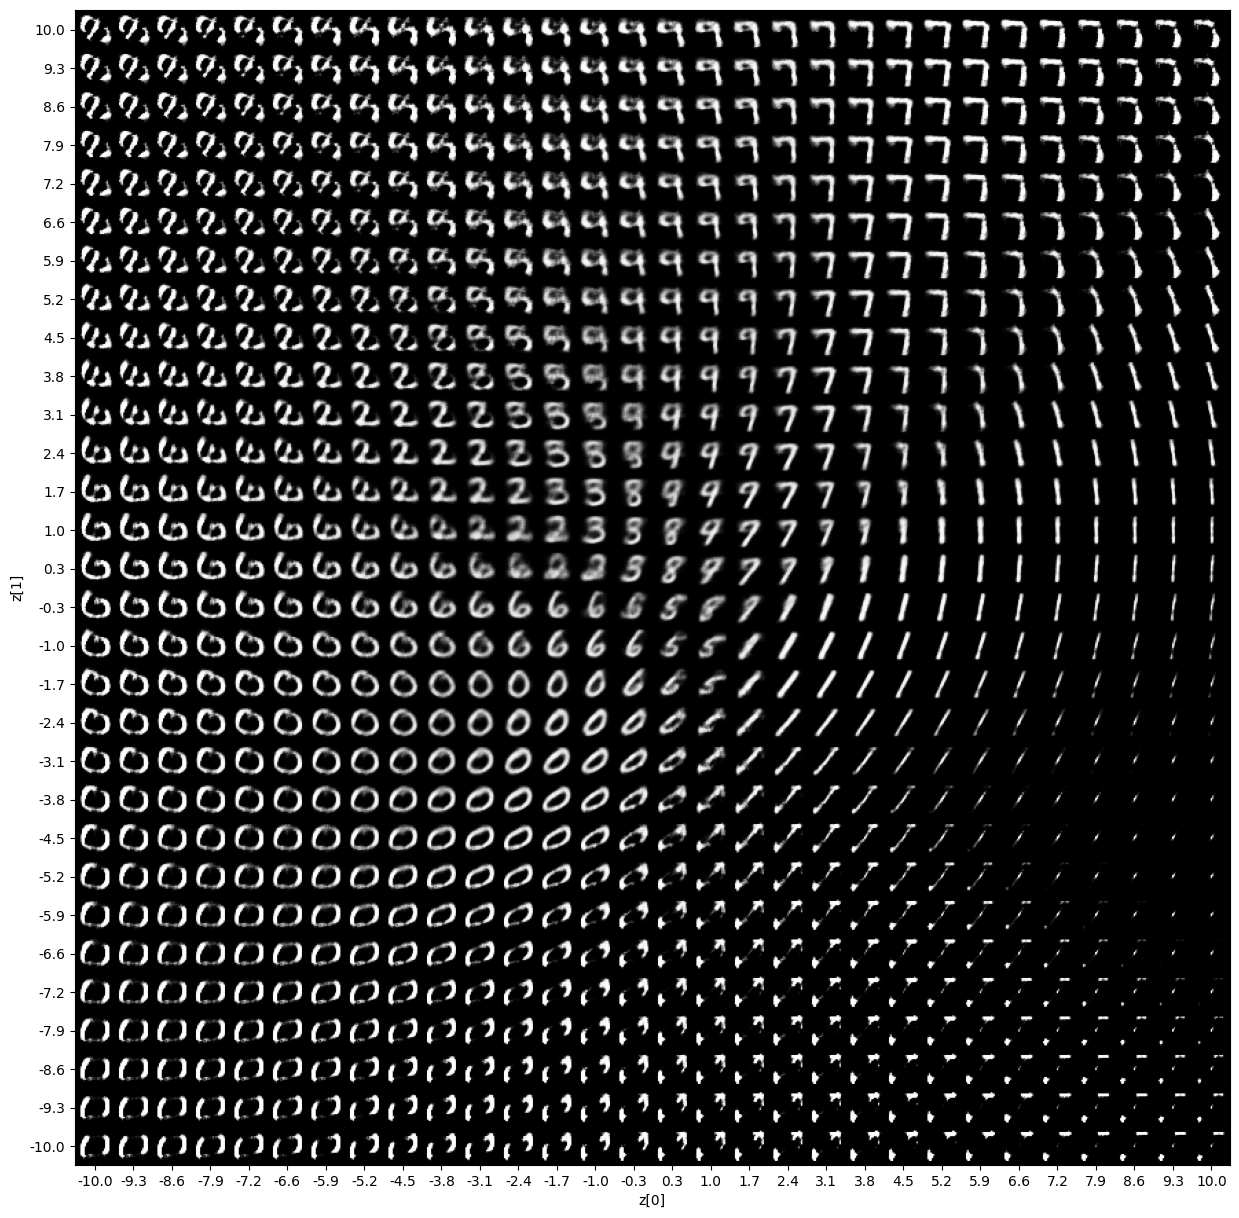

In [ ]:
# plot del map z -> immagine

# plotta una matrice nxn di immagini generate dal decoder della AE ottenute facendo uno scan delle due dimensioni latenti [z1,z2]
# cercate di capire cosa fa questa funzione

model_ae.eval()
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([xi, yi]).float() #vettore z
            z_sample = z_sample.view(1,2)
            z_sample=z_sample.to(device)
            x_decoded = decoder(z_sample) #decoder(z)
            x_decoded=x_decoded.cpu()
            digit = x_decoded[0].view(28,28).detach().numpy() #(1,28,28) -> (28,28)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(decoder)

**Confronto con PCA**

explained variance componente:  0  =  0.0977143841637429
explained variance componente:  1  =  0.07274583504996744
Explained variance totale delle prime 2 componenti della PCA: 0.17046021921371035


Text(0, 0.5, '$PCA_1$')

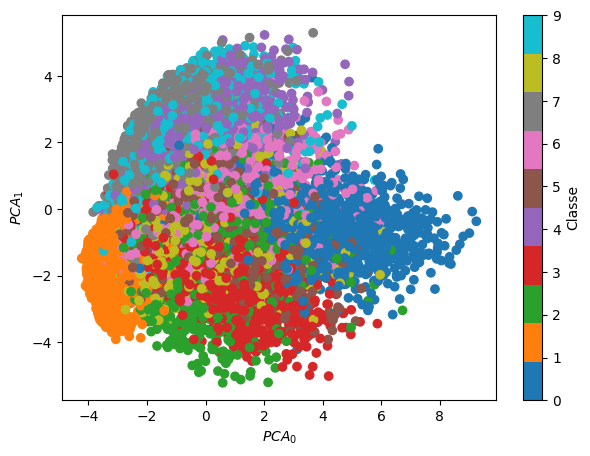

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(X_test)

exp_var = pca.explained_variance_ratio_

for i in range(0,len(exp_var)):
  print('explained variance componente: ',i, ' = ', exp_var[i])
print('Explained variance totale delle prime 2 componenti della PCA: {}'.format(sum(exp_var)))

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c=Y_test, cmap='tab10')
cbar = plt.colorbar()
cbar.set_label('Classe')
plt.xlabel('$PCA_0$')
plt.ylabel('$PCA_1$')

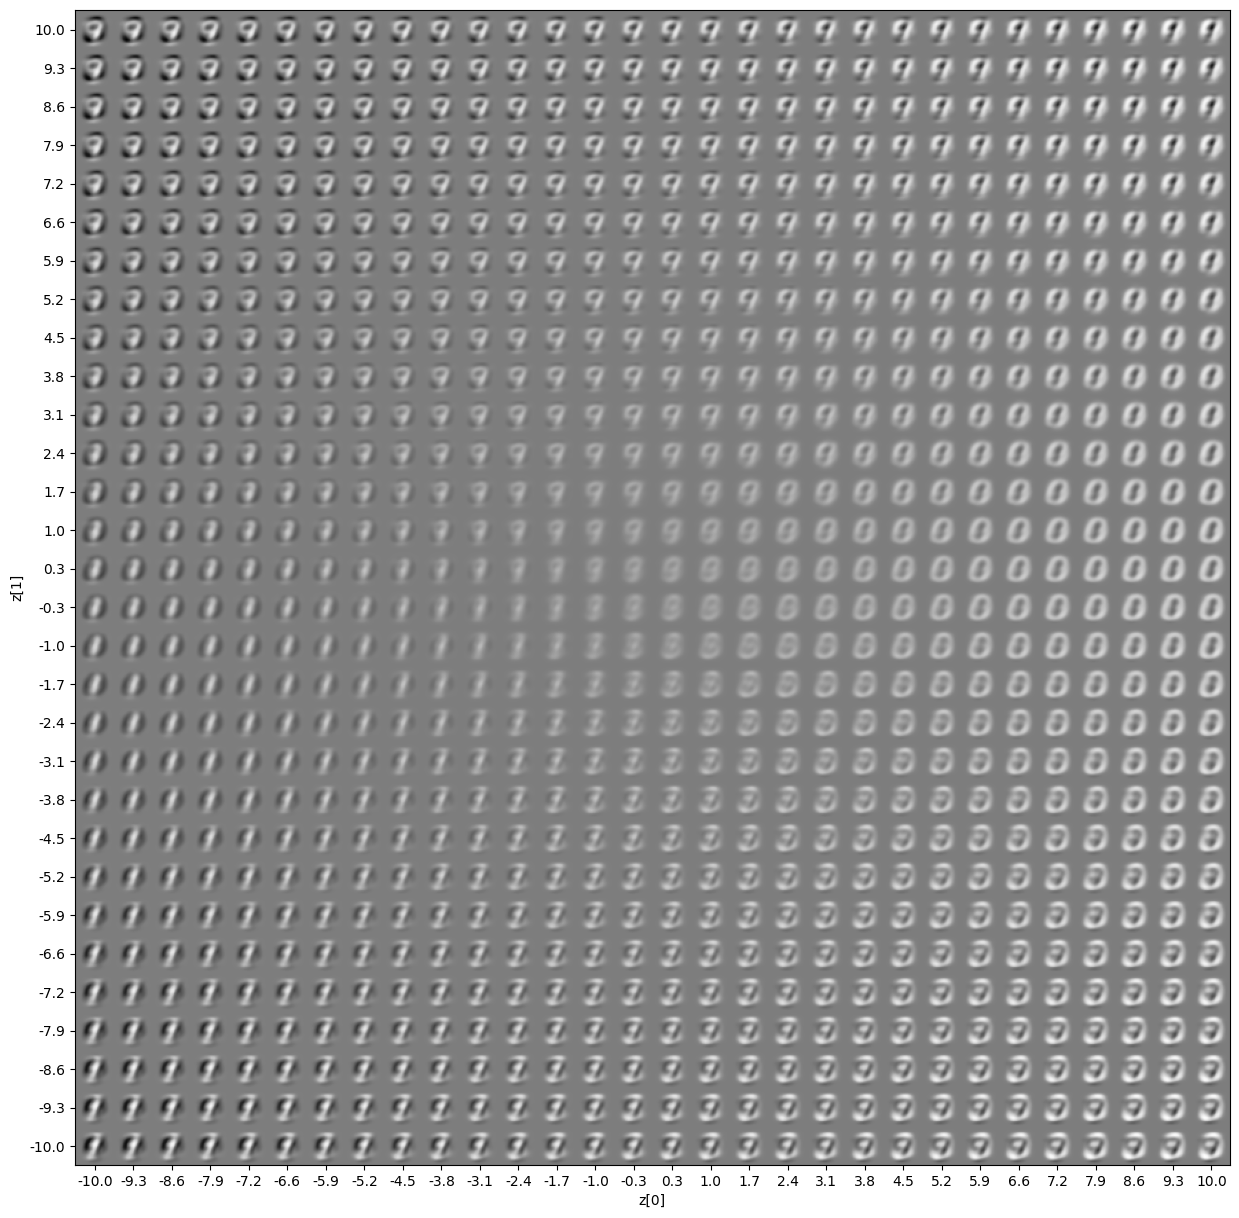

In [ ]:
# plot del map pca -> immagine

# plotta una matrice nxn di immagini generate dalla PCA ottenute facendo uno scan delle due dimensioni latenti [pca1,pca2]
# cercate di capire cosa fa questa funzione e in cosa differsice da quella usata per l'AE

def plot_latent_pca():
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi, yi]) #vettore z
            x_decoded = pca.inverse_transform(z_sample) #inversa della PCA
            digit = x_decoded.reshape((28,28))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_pca()

## Uso dell'AE come Anomaly Detector

Il rilevamento delle anomalie descrive una classe di algoritmi che mira all'identificazione di elementi, eventi o osservazioni rari, che si discostano in modo significativo dalla maggior parte dei dati e non sono conformi a una nozione ben definita di comportamento normale.

L'idea è quella di allenare l'AE solo con un tipo di eventi (normali), e poi usare la cross entropia tra input e output ricostruito oppure una aggregazione dello spazio latente (per esempio la somma degli elementi di z) come misure di anomalia. Ci si aspetta infatti che un evento del tipo normale e un evento in input diverso siano ricostruiti in modo diverso dall'AE e/o abbiano una rappresentazione compressa latente diversa.

Proviamo per esempio ad allenare l'AE solo con i caratteri 0 e poi verificare come si comporta se gli si passano caratteri 1.

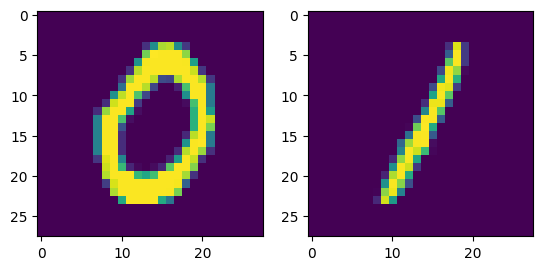

In [ ]:
# costruiamo due dataset con gli eventi MNIST 0 e 1

mnist0 = X_train[Y_train==0]
mnist1 = X_train[Y_train==1]

plt.subplot(1,2,1)
plt.imshow(mnist0[7].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(mnist1[11].reshape((28,28)))

In [ ]:
# convertiamo in torch tensor

X0 = torch.Tensor(mnist0).float()
X1 = torch.Tensor(mnist1).float()

# reshape the tensori da (n,784) a (n,1,28,28) come richiesto da conv layer in pytorch

X0 = X0.view((X0.shape[0],1,28,28))
X1 = X1.view((X1.shape[0],1,28,28))

X0_dataset = TensorDataset(X0, X0)

ds0, ds0t = torch.utils.data.random_split(X0_dataset, [int(0.9*len(X0_dataset)), len(X0_dataset) - int(0.9*len(X0_dataset))])

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

ds0_dl = DataLoader(ds0, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

ds0t_dl = DataLoader(ds0t, batch_size=1, shuffle=True, num_workers=1, drop_last=True)

ds1 = TensorDataset(X1, X1)
ds1_dl = DataLoader(ds1, batch_size=1, shuffle=True, num_workers=1, drop_last=True)



In [ ]:
# Training


# Istanziamo il modello

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy (implementata a mano, se si vuole si puo' usare BCELoss pytorch direttamente)
def vae_loss(recon_x, x):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784))
    return recon_loss

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
# Training loop

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in ds0_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = vae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 0.4084, train loss: 0.332223
epoch: 2, time(s): 0.3140, train loss: 0.228235
epoch: 3, time(s): 0.3152, train loss: 0.214716
epoch: 4, time(s): 0.3139, train loss: 0.208018
epoch: 5, time(s): 0.3109, train loss: 0.202486
epoch: 6, time(s): 0.3291, train loss: 0.198671
epoch: 7, time(s): 0.3140, train loss: 0.196127
epoch: 8, time(s): 0.3111, train loss: 0.194053
epoch: 9, time(s): 0.3219, train loss: 0.192441
epoch: 10, time(s): 0.3249, train loss: 0.191282
epoch: 11, time(s): 0.3078, train loss: 0.190199
epoch: 12, time(s): 0.3146, train loss: 0.189897
epoch: 13, time(s): 0.3166, train loss: 0.188976
epoch: 14, time(s): 0.3620, train loss: 0.188207
epoch: 15, time(s): 0.4512, train loss: 0.187810
epoch: 16, time(s): 0.4664, train loss: 0.186934
epoch: 17, time(s): 0.4799, train loss: 0.186469
epoch: 18, time(s): 0.4715, train loss: 0.185992
epoch: 19, time(s): 0.4594, train loss: 0.185506
epoch: 20, time(s): 0.3153, train loss: 0.184946
epoch: 21, time(s): 0.3106, t

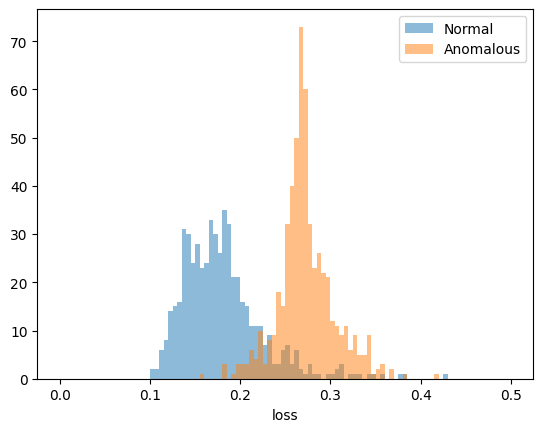

In [ ]:
# Plot distribution of the BCELoss for test 0 and 1 events

model_ae.eval()

ev0_loss = []
ev1_loss = []

with torch.no_grad():
  for xb, _ in ds0t_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev0_loss.append(loss.item())

  for xb, _ in ds1_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev1_loss.append(loss.item())

plt.hist(ev0_loss, bins=100, range=[0,0.5], label='Normal', alpha=0.5)
plt.hist(ev1_loss[:len(ev0_loss)], bins=100, range=[0,0.5], label='Anomalous', alpha=0.5)
plt.xlabel("loss")
plt.legend()
plt.show()